In [13]:
import dgl
import torch
import networkx as nx
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [15]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


D:\ProgramData\Anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


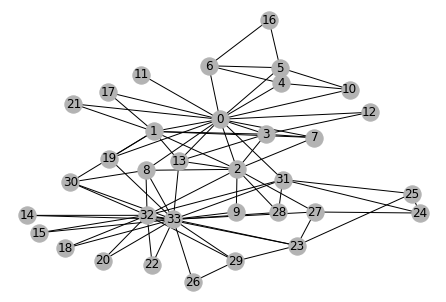

In [16]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [17]:
G.ndata['feat'] = torch.eye(34)

In [18]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

gcn_msg=fn.copy_src(src='h',out='m')

gcn_reduce=fn.sum(msg='m',out='h')


# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] =feature
            g.update_all(gcn_msg,gcn_reduce)
            h=g.ndata['h']
        return self.linear(h)

In [20]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

# 以空手道俱乐部为例
# 第一层将34层的输入转化为隐层为5
# 第二层将隐层转化为最终的分类数2
net = GCN(34,5,2)

In [21]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [22]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7452
Epoch 1 | Loss: 0.5989
Epoch 2 | Loss: 0.4840
Epoch 3 | Loss: 0.3784
Epoch 4 | Loss: 0.2811
Epoch 5 | Loss: 0.1967
Epoch 6 | Loss: 0.1310
Epoch 7 | Loss: 0.0828
Epoch 8 | Loss: 0.0504
Epoch 9 | Loss: 0.0301
Epoch 10 | Loss: 0.0176
Epoch 11 | Loss: 0.0105
Epoch 12 | Loss: 0.0064
Epoch 13 | Loss: 0.0041
Epoch 14 | Loss: 0.0026
Epoch 15 | Loss: 0.0018
Epoch 16 | Loss: 0.0012
Epoch 17 | Loss: 0.0008
Epoch 18 | Loss: 0.0006
Epoch 19 | Loss: 0.0004
Epoch 20 | Loss: 0.0003
Epoch 21 | Loss: 0.0003
Epoch 22 | Loss: 0.0002
Epoch 23 | Loss: 0.0002
Epoch 24 | Loss: 0.0001
Epoch 25 | Loss: 0.0001
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0001
Epoch 28 | Loss: 0.0001
Epoch 29 | Loss: 0.0001


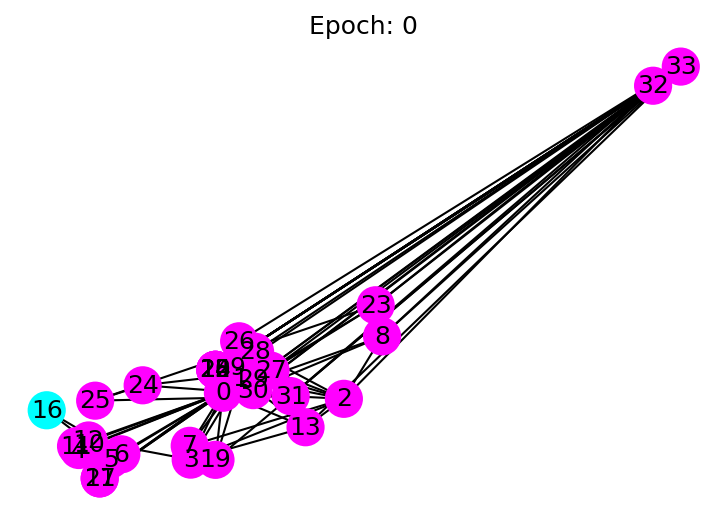

In [23]:
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.close()

In [24]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=300)
ani.save('result.gif')
plt.show()